In [1]:
import os, json, torch, xarray as xr, numpy as np
from torch.utils.data import Dataset

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import time

In [2]:
class ZScore:
    def __init__(self, mean, std, eps=1e-7):
        self.mean = torch.as_tensor(mean)
        self.std  = torch.as_tensor(std) + eps

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        view = ( -1, ) + (1,)*(x.ndim-1)          # (C,1,1)  or  (C,)
        return (x - self.mean.view(*view)) / self.std.view(*view)

class CombinedDataset(Dataset):
    """
    returns
        static_tensor: (C_static, 360, 360) – 33 channels (for now), z-scored
        dyn_vector: (2,) – IMERG, SMAP, z-scored
        target_tensor: (1, 360, 360)
    """
    def __init__(self,
                 root_dir: str,
                 static_stats_file: str,
                 dynamic_stats_file: str,
                 static_vars = None,
                 dynamic_vars = None,
                 time_inds = None,
                 listoftiles= None):

        self.root_dir = root_dir

        # Var names
        if static_vars is None:
            with xr.open_dataset(os.path.join(root_dir,
                                              (listoftiles or os.listdir(root_dir))[0],
                                              "static.nc")) as ds:
                static_vars = list(ds.data_vars)
        if dynamic_vars is None:
            with xr.open_dataset(os.path.join(root_dir,
                                              (listoftiles or os.listdir(root_dir))[0],
                                              "dynamic.nc")) as ds:
                dynamic_vars = list(ds.data_vars)

        self.static_vars, self.dynamic_vars = static_vars, dynamic_vars

        # Tile timestamp list
        self.tiles = listoftiles or sorted(os.listdir(root_dir))
        if time_inds is None:
            with xr.open_dataset(os.path.join(root_dir, self.tiles[0],
                                              "dynamic.nc")) as ds:
                time_inds = range(len(ds.time))
        self.samples = [(tile, t) for tile in self.tiles for t in time_inds]

        # Get norm stats for static and dynamic separately
        with open(static_stats_file)  as f: s_stats = json.load(f)
        with open(dynamic_stats_file) as f: d_stats = json.load(f)

        # Use helper function to normalize w dataset-specific stats
        self.norm_static = ZScore([s_stats[v]['mean'] for v in self.static_vars],
                                  [s_stats[v]['std']  for v in self.static_vars])

        self.norm_dyn    = ZScore([d_stats[v]['mean'] for v in self.dynamic_vars],
                                  [d_stats[v]['std']  for v in self.dynamic_vars])


    def __len__(self): return len(self.samples)
    
    
    def __getitem__(self, idx):
        tile, t  = self.samples[idx]
        basepath = os.path.join(self.root_dir, tile)

        static_arr = xr.open_dataset(os.path.join(basepath, "static.nc"))[self.static_vars].to_array().values

        dyn_arr = xr.open_dataset(os.path.join(basepath, "dynamic.nc")).isel(time=t).to_array().values

        target_arr = xr.open_dataset(os.path.join(basepath, "target.nc")).isel(time=t).to_array().values

        static_tensor = self.norm_static(torch.as_tensor(static_arr, dtype=torch.float32))

        dyn_vector = self.norm_dyn(
                            torch.as_tensor(dyn_arr[:,0,0], dtype=torch.float32)  # Instead of 2D, just vector; fill it out with unet class
                        )

        target_tensor = torch.as_tensor(target_arr, dtype=torch.float32)

        return static_tensor, dyn_vector, target_tensor


In [3]:
workspace = os.path.dirname(os.path.dirname(os.getcwd()))
root_dir = f"{workspace}/data/combined_output/tiles2"

ds = xr.open_dataset(os.path.join(workspace, "data", "combined_output", "tiles2", "tile_0_0", "dynamic.nc"))
time_inds = list(range(0, (len(ds.time.values))))

years = ds.time.values.astype("datetime64[Y]").astype(int) + 1970

# Take time slices from 2016-2018, stepping by 10
# time_inds = list(range(list(years).index(2016), list(years).index(2018), 10))

train_time_inds = list(range(list(years).index(2016), list(years).index(2017), 10))
test_time_inds = list(range(list(years).index(2017), list(years).index(2018), 10))

# train_tiles = []
# test_tiles = []

# # If I was doing the checkerboard thing
# for i in range(10):
#     for j in range(10):
#         new_tile = f"tile_{i}_{j}"
#         if (i + j) % 2 == 0:
#             train_tiles.append(new_tile)
#         else:
#             test_tiles.append(new_tile)

static_vars = ['bd_0_5',
                 'bd_60_100',
                 'clay_0_5',
                 'commercial',
                 'cropland',
                 'elevation',
                 'exurban_high',
                 'exurban_low',
                 'grazing',
                 'hb_0_5',
                 'industrial',
                 'institutional',
                 'ksat_0_5',
                 'mining_barren_land',
                 'n_0_5',
                 'natural_water',
                 'om_0_5',
                 'parks_golf_courses',
                 'pasture',
                 'ph_0_5',
                 'ph_60_100',
                 'recreation_conservation',
                 'reservoirs_canals',
                 'sand_0_5',
                 'silt_0_5',
                 'suburban',
                 'theta_r_0_5',
                 'theta_s_0_5',
                 'timber',
                 'transportation',
                 'urban_high',
                 'urban_low',
                 'wetlands']

training_set = CombinedDataset(root_dir, time_inds=train_time_inds, static_vars=static_vars,
                              static_stats_file=os.path.join(workspace, "data", "combined_output", "static_norm_stats.json"),
                              dynamic_stats_file=os.path.join(workspace, "data", "combined_output", "dynamic_norm_stats.json"))
validation_set = CombinedDataset(root_dir, time_inds=test_time_inds, static_vars=static_vars,
                                 static_stats_file=os.path.join(workspace, "data", "combined_output", "static_norm_stats.json"),
                                 dynamic_stats_file=os.path.join(workspace, "data", "combined_output", "dynamic_norm_stats.json"))

batch_size = 100
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

dynamic vector shape: torch.Size([100, 2]) 
values: [1.0479779 1.3134087]


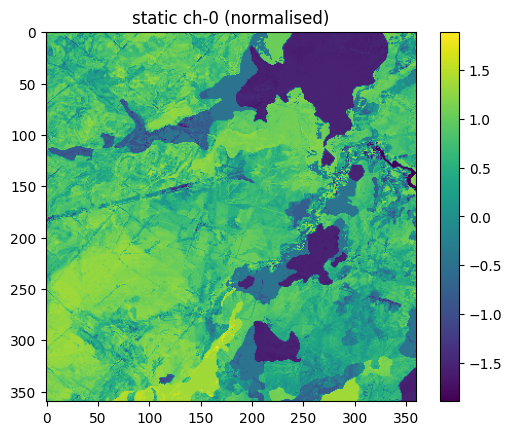

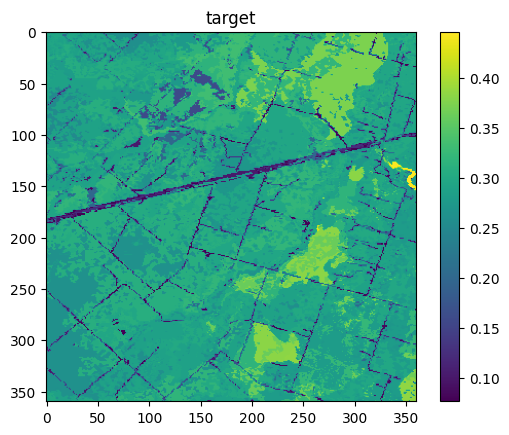

In [4]:
# Check dimensions
for static, dyn, target in training_loader:
    fig1, ax1 = plt.subplots()
    im1 = ax1.imshow(static[0, 0].cpu(), cmap='viridis')
    fig1.colorbar(im1, ax=ax1)          # <- colour-bar
    ax1.set_title("static ch-0 (normalised)")
    
    fig2, ax2 = plt.subplots()
    im2 = ax2.imshow(target[0, 0].cpu(), cmap='viridis')
    fig2.colorbar(im2, ax=ax2)          # <- colour-bar
    ax2.set_title("target")

    print("dynamic vector shape:", dyn.shape, "\nvalues:", dyn[0].cpu().numpy())
    plt.show()
    break

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def pad_to_target(x, target_size):
    """
    Pad tensor `x` (N,C,H,W) so its spatial size matches `target_size=(H_t,W_t)`.
    """
    _, _, h, w = x.shape
    target_h, target_w = target_size
    pad_h = target_h - h
    pad_w = target_w - w
    pad_top,  pad_bottom = pad_h // 2,  pad_h - pad_h // 2
    pad_left, pad_right  = pad_w // 2,  pad_w - pad_w // 2
    return F.pad(x, [pad_left, pad_right, pad_top, pad_bottom])


class UNetFusionExplicit(nn.Module):
    """
    7 encoder blocks, 6 decoder blocks, skip connections, and drop out.
    """
    def __init__(
        self,
        in_channels_static: int = 33,
        dyn_channels: int = 2,
        out_channels: int = 1,
        inject_level: int = -2, 
    ):
        super().__init__()

        #  Encoder: channels 32-64-128-256-512-512-1024
        self.inject_level = inject_level % 7 # adjust to be in range
        self.dyn_channels = dyn_channels

        # block 0: 33 (in_channels) to 32
        self.d0_conv1 = nn.Conv2d(in_channels_static, 32, 3, padding=1)
        self.d0_drop1 = nn.Dropout2d(0.2)
        self.d0_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool0    = nn.MaxPool2d(2, 2)

        # Function to choose correct number of channels if it's time to inject the dynamic
        def in_ch(prev_out, idx):          # idx = current block index
            if idx - 1 == self.inject_level:
                return prev_out + dyn_channels
            return prev_out

        # block 1: 32 to 64
        self.d1_conv1 = nn.Conv2d(in_ch(32, 1), 64, 3, padding=1)
        self.d1_drop1 = nn.Dropout2d(0.2)
        self.d1_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1    = nn.MaxPool2d(2, 2)

        # block 2: 64 to 128
        self.d2_conv1 = nn.Conv2d(in_ch(64, 2), 128, 3, padding=1)
        self.d2_drop1 = nn.Dropout2d(0.2)
        self.d2_conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2    = nn.MaxPool2d(2, 2)

        # block 3: 128 to 256
        self.d3_conv1 = nn.Conv2d(in_ch(128, 3), 256, 3, padding=1)
        self.d3_drop1 = nn.Dropout2d(0.2)
        self.d3_conv2 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3    = nn.MaxPool2d(2, 2)

        # block 4: 256 to 512
        self.d4_conv1 = nn.Conv2d(in_ch(256, 4), 512, 3, padding=1)
        self.d4_drop1 = nn.Dropout2d(0.2)
        self.d4_conv2 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4    = nn.MaxPool2d(2, 2)

        # block 5: 512 to 512
        self.d5_conv1 = nn.Conv2d(in_ch(512, 5), 512, 3, padding=1)
        self.d5_drop1 = nn.Dropout2d(0.2)
        self.d5_conv2 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool5    = nn.MaxPool2d(2, 2)

        # block 6: 512 to 1024
        self.d6_conv1 = nn.Conv2d(in_ch(512, 6), 1024, 3, padding=1)
        self.d6_drop1 = nn.Dropout2d(0.2)
        self.d6_conv2 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.pool6    = nn.MaxPool2d(2, 2)   # will produce 2×2 for 360-pixel inputs

        #  Decoder ― up-convs followed by two plain convs (ReLU + Dropout + ReLU)

        # up-5: 1024 to 512, skip = 512
        self.up5_convT = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.u5_conv1  = nn.Conv2d(1024, 512, 3, padding=1)
        self.u5_drop1  = nn.Dropout2d(0.2)
        self.u5_conv2  = nn.Conv2d(512, 512, 3, padding=1)

        # up-4: 512 to 512, skip = 512
        self.up4_convT = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.u4_conv1  = nn.Conv2d(1024, 512, 3, padding=1)
        self.u4_drop1  = nn.Dropout2d(0.2)
        self.u4_conv2  = nn.Conv2d(512, 512, 3, padding=1)

        # up-3: 512 to 256, skip = 256
        self.up3_convT = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.u3_conv1  = nn.Conv2d(512, 256, 3, padding=1)
        self.u3_drop1  = nn.Dropout2d(0.2)
        self.u3_conv2  = nn.Conv2d(256, 256, 3, padding=1)

        # up-2: 256 to 128, skip = 128
        self.up2_convT = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.u2_conv1  = nn.Conv2d(256, 128, 3, padding=1)
        self.u2_drop1  = nn.Dropout2d(0.2)
        self.u2_conv2  = nn.Conv2d(128, 128, 3, padding=1)

        # up-1: 128 to 64, skip = 64
        self.up1_convT = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.u1_conv1  = nn.Conv2d(128, 64, 3, padding=1)
        self.u1_drop1  = nn.Dropout2d(0.2)
        self.u1_conv2  = nn.Conv2d(64, 64, 3, padding=1)

        # up-0: 64 to 32, skip = 32
        self.up0_convT = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.u0_conv1  = nn.Conv2d(64, 32, 3, padding=1)
        self.u0_drop1  = nn.Dropout2d(0.2)
        self.u0_conv2  = nn.Conv2d(32, 32, 3, padding=1)

        # final 1×1
        
        self.out_conv = nn.Conv2d(32, out_channels, 1)

    # Define forward pass
    def forward(self, x_static, dyn_vec):
        """
        x_static: (B, 33, 360, 360)
        dyn_vec: (B, 2)         – injected after encoder block `inject_level`
        """
        # Encoder
        # block 0: 33 to 32
        x = F.relu(self.d0_conv1(x_static))
        x = self.d0_drop1(x)
        x = F.relu(self.d0_conv2(x))
        skip0 = x # 32
        x = self.pool0(x) if x.shape[-2] > 1 and x.shape[-1] > 1 else x
        if self.inject_level == 0:
            dyn = dyn_vec[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
            x = torch.cat([x, dyn], dim=1)

        # block 1: 32 to 64
        x = F.relu(self.d1_conv1(x))
        x = self.d1_drop1(x)
        x = F.relu(self.d1_conv2(x))
        skip1 = x # 64
        x = self.pool1(x)
        if self.inject_level == 1:
            dyn = dyn_vec[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
            x = torch.cat([x, dyn], dim=1)

        # block 2: 64 to 128
        x = F.relu(self.d2_conv1(x))
        x = self.d2_drop1(x)
        x = F.relu(self.d2_conv2(x))
        skip2 = x # 128
        x = self.pool2(x)
        if self.inject_level == 2:
            dyn = dyn_vec[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
            x = torch.cat([x, dyn], dim=1)

        # block 3: 128 to 256
        x = F.relu(self.d3_conv1(x))
        x = self.d3_drop1(x)
        x = F.relu(self.d3_conv2(x))
        skip3 = x # 256
        x = self.pool3(x)
        if self.inject_level == 3:
            dyn = dyn_vec[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
            x = torch.cat([x, dyn], dim=1)

        # block 4: 256 to 512
        x = F.relu(self.d4_conv1(x))
        x = self.d4_drop1(x)
        x = F.relu(self.d4_conv2(x))
        skip4 = x # 512
        x = self.pool4(x)
        if self.inject_level == 4:
            dyn = dyn_vec[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
            x = torch.cat([x, dyn], dim=1)

        # block 5: 512 to 512
        x = F.relu(self.d5_conv1(x))
        x = self.d5_drop1(x)
        x = F.relu(self.d5_conv2(x))
        skip5 = x # 512
        x = self.pool5(x)
        if self.inject_level == 5:
            dyn = dyn_vec[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
            x = torch.cat([x, dyn], dim=1)

        # block 6: 512 to 1024
        x = F.relu(self.d6_conv1(x))
        x = self.d6_drop1(x)
        x = F.relu(self.d6_conv2(x))
        skip6 = x # not used

        # Decoder
        # up-5
        x = self.up5_convT(x) # 1024 to 512
        if x.size(2) != skip5.size(2) or x.size(3) != skip5.size(3):
            x = pad_to_target(x, skip5.shape[-2:])
        x = torch.cat([skip5, x], dim=1) # add 512
        x = F.relu(self.u5_conv1(x))
        x = self.u5_drop1(x)
        x = F.relu(self.u5_conv2(x))

        # up-4
        x = self.up4_convT(x) # 512 to 512
        if x.size(2) != skip4.size(2) or x.size(3) != skip4.size(3):
            x = pad_to_target(x, skip4.shape[-2:])
        x = torch.cat([skip4, x], dim=1) # add 512
        x = F.relu(self.u4_conv1(x))
        x = self.u4_drop1(x)
        x = F.relu(self.u4_conv2(x))

        # up-3
        x = self.up3_convT(x) # 512 to 256
        if x.size(2) != skip3.size(2) or x.size(3) != skip3.size(3):
            x = pad_to_target(x, skip3.shape[-2:])
        x = torch.cat([skip3, x], dim=1) # add 256
        x = F.relu(self.u3_conv1(x))
        x = self.u3_drop1(x)
        x = F.relu(self.u3_conv2(x))

        # up-2
        x = self.up2_convT(x) # 256 to 128
        if x.size(2) != skip2.size(2) or x.size(3) != skip2.size(3):
            x = pad_to_target(x, skip2.shape[-2:])
        x = torch.cat([skip2, x], dim=1) # add 128
        x = F.relu(self.u2_conv1(x))
        x = self.u2_drop1(x)
        x = F.relu(self.u2_conv2(x))

        # up-1
        x = self.up1_convT(x) # 128 to 64
        if x.size(2) != skip1.size(2) or x.size(3) != skip1.size(3):
            x = pad_to_target(x, skip1.shape[-2:])
        x = torch.cat([skip1, x], dim=1) # add 64
        x = F.relu(self.u1_conv1(x))
        x = self.u1_drop1(x)
        x = F.relu(self.u1_conv2(x))

        # up-0
        x = self.up0_convT(x) # 64 to 32
        if x.size(2) != skip0.size(2) or x.size(3) != skip0.size(3):
            x = pad_to_target(x, skip0.shape[-2:])
        x = torch.cat([skip0, x], dim=1) # add 32
        x = F.relu(self.u0_conv1(x))
        x = self.u0_drop1(x)
        x = F.relu(self.u0_conv2(x))

        # output
        return self.out_conv(x) # 32 to out_channels


In [6]:
model = UNetFusionExplicit(inject_level=-2)   # example
dummy_x = torch.randn(4, 33, 360, 360)
dummy_dyn = torch.randn(4, 2)
y = model(dummy_x, dummy_dyn)                 # (4, 1, 360, 360)
print(y.shape)
# torch.Size([4, 1, 360, 360])


torch.Size([4, 1, 360, 360])


In [7]:
# quick backward pass
y.sum().backward()          # should run without error
print("Grad OK?       ",
      all(p.grad is not None for p in model.parameters() if p.requires_grad))

# parameter count
total_params = sum(p.numel() for p in model.parameters())
print("Total params  :", f"{total_params:,}")

Grad OK?        True
Total params  : 43,969,185


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetFusionExplicit(in_channels_static=33, out_channels=1).to(device) # 33 instead of 35 bc don't add dynamic immediately

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Try it for just one epoch on the training data
def train_one_epoch(epoch, writer=None):
    model.train()
    total_loss = 0.0
    start_epoch_time = time.time()

    for static_maps, dyn_vec, target in training_loader:     
        static_maps = static_maps.to(device)
        dyn_vec     = dyn_vec.to(device)
        target      = target.to(device)

        pred  = model(static_maps, dyn_vec)                 
        loss  = loss_fn(pred, target)                       

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_time = time.time() - start_epoch_time
    print(f"Epoch {epoch} finished in {epoch_time:.2f} seconds")

    # Average loss
    avg_loss = total_loss / len(training_loader)
    print(f"Epoch {epoch}, average train loss={avg_loss:.4f}")

    if writer is not None:
        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Timing/train_epoch_seconds", epoch_time, epoch)

    return avg_loss


In [14]:
avg_loss = train_one_epoch(1)
print(avg_loss)

Epoch 1 finished in 421.82 seconds
Epoch 1, average train loss=0.0476
0.04757320139881061
